# Toxic Content Classification - Hybrid ML Model


## Objective
Build a **Hybrid Classification System** combining Rule-based Filter + Naive Bayes ML Model.


### Pipeline Architecture:
```
[Input Text]
     ↓
[Text Preprocessing & Cleaning]
     ↓
[Rule-based Filter] (ToxicPhraseDetector)
     ↓
[If toxic phrases detected] → [VIOLATION]
     ↓ (No toxic phrases)
[Naive Bayes ML Model] → Predict probability
     ↓
[If prob > threshold] → [VIOLATION]
     ↓
[Else] → [SAFE]
```


### Features:
- **Rule-based Filter**: Detects known toxic phrases from slang dictionary
- **ML Model**: Naive Bayes (Multinomial + ComplementNB) with hyperparameter tuning
- **Dataset**: `Only_Model/train.csv` (Jigsaw Toxic Comment Challenge with toxic/severe/obscene/threat/insult/identity_hate flags)
- **Binary Classification**: Safe (0) vs Violation (any toxic flag = 1)

## 1. Environment Setup & Imports

In [1]:
# Install required packages (uncomment if needed)
!pip install pandas numpy scikit-learn matplotlib seaborn nltk imbalanced-learn

In [2]:
# Install tokenizers library for BPE
!pip install tokenizers

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import warnings
from pathlib import Path
import sys

# Text preprocessing
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# Byte-level BPE Tokenizer
from tokenizers import ByteLevelBPETokenizer
from tokenizers.processors import BertProcessing

# Feature extraction
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

# Naive Bayes models
from sklearn.naive_bayes import MultinomialNB, ComplementNB, BernoulliNB

# Model evaluation
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix, roc_auc_score, roc_curve
)

# Imbalanced data handling
from imblearn.over_sampling import SMOTE

# Save model
import joblib
import pickle

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

print("✓ All libraries imported successfully")

✓ All libraries imported successfully


In [4]:
# Download NLTK data
nltk.download('stopwords', quiet=True)
nltk.download('punkt', quiet=True)
nltk.download('punkt_tab', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('averaged_perceptron_tagger', quiet=True)
print("✓ NLTK data downloaded")

✓ NLTK data downloaded


## 2. Import Rule-based ToxicPhraseDetector

In [5]:
# Find project root and import model
def find_project_root(start: Path = Path.cwd(), target: str = 'Data/slang.csv', max_up: int = 6):
    """Search up from start for a directory containing the target file."""
    p = start.resolve()
    for _ in range(max_up + 1):
        if (p / target).exists():
            return p
        if p.parent == p:
            break
        p = p.parent
    return None

# Get project root
project_root = find_project_root() or Path.cwd()
print(f"Project root: {project_root}")

# Add to sys.path
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

# Import ToxicPhraseDetector
try:
    from CrawlData.model import ToxicPhraseDetector
    print("✓ ToxicPhraseDetector imported successfully")
except Exception as e:
    print(f"Warning: Could not import ToxicPhraseDetector: {e}")
    print("Rule-based filter will be disabled")
    ToxicPhraseDetector = None

Project root: D:\SE405\SE400_Seminar_CNPM_final
✓ ToxicPhraseDetector imported successfully


In [6]:
# Initialize Rule-based Detector (if available)
rule_based_detector = None

if ToxicPhraseDetector is not None:
    try:
        slang_csv_path = project_root / 'Data' / 'slang.csv'
        if slang_csv_path.exists():
            rule_based_detector = ToxicPhraseDetector(
                slang_csv_path=str(slang_csv_path),
                toxic_threshold=3
            )
            stats = rule_based_detector.get_statistics()
            print("✓ Rule-based Detector initialized")
            print(f"  Total toxic phrases: {stats.get('total_toxic_phrases', 'N/A')}")
        else:
            print(f"Warning: slang.csv not found at {slang_csv_path}")
    except Exception as e:
        print(f"Warning: Could not initialize detector: {e}")
else:
    print("Rule-based detector not available")

Loaded 901 unique toxic phrases from 874 entries (including root words)
✓ Rule-based Detector initialized
  Total toxic phrases: 901


## 3. Load and Explore Data

In [7]:
# Load dataset - Kaggle Toxic Comment Challenge (train.csv)
data_path = project_root / 'Data' / 'train.csv'
df = pd.read_csv(data_path)


print("Dataset: train.csv (Jigsaw Toxic Comment Challenge)")
print(f"Dataset path: {data_path}")
print(f"Dataset shape: {df.shape}")


# Align column names with previous pipeline
if 'comment_text' in df.columns:
    df = df.rename(columns={'comment_text': 'tweet'})


label_columns = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
missing_cols = [col for col in label_columns if col not in df.columns]
if missing_cols:
    raise ValueError(f"Missing label columns in train.csv: {missing_cols}")


# Collapse multi-label targets into binary Safe (0) vs Violation (1)
df['class'] = (df[label_columns].max(axis=1)).astype(int)


print("\nLabel coverage per toxicity flag:")
for col in label_columns:
    positives = int(df[col].sum())
    pct = 100 * positives / len(df)
    print(f"  {col:>13}: {positives:7d} positives ({pct:5.2f}%)")


class_counts = df['class'].value_counts().sort_index()
print("\nBinary Safe vs Violation distribution:")
print({('Safe' if idx == 0 else 'Violation'): int(count) for idx, count in class_counts.items()})


print("\nFirst 5 rows:")
display(df.head())

Dataset: train.csv (Jigsaw Toxic Comment Challenge)
Dataset path: D:\SE405\SE400_Seminar_CNPM_final\Data\train.csv
Dataset shape: (159571, 8)

Label coverage per toxicity flag:
          toxic:   15294 positives ( 9.58%)
   severe_toxic:    1595 positives ( 1.00%)
        obscene:    8449 positives ( 5.29%)
         threat:     478 positives ( 0.30%)
         insult:    7877 positives ( 4.94%)
  identity_hate:    1405 positives ( 0.88%)

Binary Safe vs Violation distribution:
{'Safe': 143346, 'Violation': 16225}

First 5 rows:


,id,tweet,toxic,severe_toxic,obscene,threat,insult,identity_hate,class
0,0000997932d777bf,Explanation\r\nWhy the edits made under my use...,0,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\r\nMore\r\nI can't make any real suggestions...",0,0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,0


In [8]:
# Dataset statistics
print("Dataset Info:")
print(df.info())
print("\n" + "="*60)
print("Missing Values:")
print(df.isnull().sum())
print("\n" + "="*60)
print("Class Distribution:")
print(df['class'].value_counts())
print("\nClass Distribution (%):")
print(df['class'].value_counts(normalize=True) * 100)

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 9 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id             159571 non-null  object
 1   tweet          159571 non-null  object
 2   toxic          159571 non-null  int64 
 3   severe_toxic   159571 non-null  int64 
 4   obscene        159571 non-null  int64 
 5   threat         159571 non-null  int64 
 6   insult         159571 non-null  int64 
 7   identity_hate  159571 non-null  int64 
 8   class          159571 non-null  int64 
dtypes: int64(7), object(2)
memory usage: 11.0+ MB
None

Missing Values:
id               0
tweet            0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
class            0
dtype: int64

Class Distribution:
class
0    143346
1     16225
Name: count, dtype: int64

Class Distribution (%):
class
0    89.832112
1    10.1678

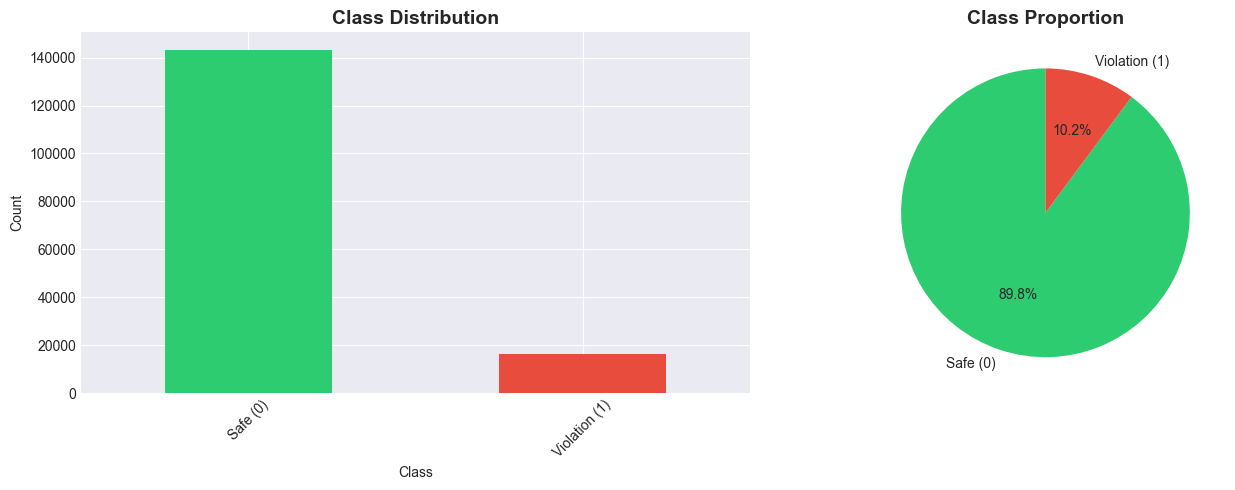

In [9]:
# Visualize class distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))


class_counts = df['class'].value_counts().sort_index()
label_map = {0: 'Safe (0)', 1: 'Violation (1)'}
color_map = {0: '#2ecc71', 1: '#e74c3c'}


# Count plot
bar_colors = [color_map.get(idx, '#95a5a6') for idx in class_counts.index]
class_counts.plot(kind='bar', ax=axes[0], color=bar_colors)
axes[0].set_title('Class Distribution', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Class')
axes[0].set_ylabel('Count')
axes[0].set_xticklabels([label_map.get(idx, f'Class {idx}') for idx in class_counts.index], rotation=45)


# Pie chart
pie_colors = [color_map.get(idx, '#95a5a6') for idx in class_counts.index]
axes[1].pie(
    class_counts,
    labels=[label_map.get(idx, f'Class {idx}') for idx in class_counts.index],
    autopct='%1.1f%%',
    colors=pie_colors,
    startangle=90
)
axes[1].set_title('Class Proportion', fontsize=14, fontweight='bold')


plt.tight_layout()
plt.show()

## 4. Data Preprocessing

In [10]:
# Remove missing values
df = df.dropna(subset=['tweet', 'class'])
print(f"Dataset shape after removing NaN: {df.shape}")

Dataset shape after removing NaN: (159571, 9)


In [11]:
# Text cleaning function
def normalize_repeated_chars(text: str, max_repeats: int = 2) -> str:
    """Collapse long character runs like 'soooo' → 'soo' for stabler models."""
    pattern = re.compile(rf"([a-zA-Z])\1{{{max_repeats},}}")
    return pattern.sub(lambda m: m.group(1) * max_repeats, text)

def clean_text(text):
    """
    Clean and preprocess text data
    """
    # Convert to string and lowercase
    text = str(text).lower()
    
    # Normalize character repetitions before further cleaning
    text = normalize_repeated_chars(text)
    
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    
    # Remove user mentions and hashtags
    text = re.sub(r'@\w+|#\w+', '', text)
    
    # Remove HTML entities
    text = re.sub(r'&\w+;|&#\d+;', '', text)
    
    # Remove special characters and numbers (keep only letters and spaces)
    text = re.sub(r'[^a-zA-Z\s]', ' ', text)
    
    # Remove extra whitespaces
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

# Apply cleaning
df['cleaned_tweet'] = df['tweet'].apply(clean_text)

print("Cleaning Examples:")
for i in range(3):
    print(f"\nOriginal: {df['tweet'].iloc[i][:80]}...")
    print(f"Cleaned:  {df['cleaned_tweet'].iloc[i][:80]}...")

Cleaning Examples:

Original: Explanation
Why the edits made under my username Hardcore Metallica Fan were re...
Cleaned:  explanation why the edits made under my username hardcore metallica fan were rev...

Original: D'aww! He matches this background colour I'm seemingly stuck with. Thanks.  (tal...
Cleaned:  d aww he matches this background colour i m seemingly stuck with thanks talk jan...

Original: Hey man, I'm really not trying to edit war. It's just that this guy is constantl...
Cleaned:  hey man i m really not trying to edit war it s just that this guy is constantly ...


In [12]:
# Advanced preprocessing with lemmatization
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    """
    Advanced preprocessing: tokenization, stopword removal, lemmatization
    """
    try:
        # Tokenize
        tokens = word_tokenize(text)
        
        # Remove stopwords and lemmatize
        tokens = [lemmatizer.lemmatize(word) for word in tokens 
                  if word not in stop_words and len(word) > 2]
        
        return ' '.join(tokens)
    except:
        return text

print("Applying advanced preprocessing...")
df['processed_tweet'] = df['cleaned_tweet'].apply(preprocess_text)
print("✓ Preprocessing completed")

# Show examples
print("\nPreprocessing Examples:")
for i in range(3):
    print(f"\nCleaned:    {df['cleaned_tweet'].iloc[i][:60]}...")
    print(f"Processed:  {df['processed_tweet'].iloc[i][:60]}...")

Applying advanced preprocessing...
✓ Preprocessing completed

Preprocessing Examples:

Cleaned:    explanation why the edits made under my username hardcore me...
Processed:  explanation edits made username hardcore metallica fan rever...

Cleaned:    d aww he matches this background colour i m seemingly stuck ...
Processed:  aww match background colour seemingly stuck thanks talk janu...

Cleaned:    hey man i m really not trying to edit war it s just that thi...
Processed:  hey man really trying edit war guy constantly removing relev...


### 4.1. Train Byte-level BPE Tokenizer

In [13]:
# Initialize and train Byte-level BPE Tokenizer
print("Training Byte-level BPE Tokenizer...")

# Initialize tokenizer
bpe_tokenizer = ByteLevelBPETokenizer()

# Create temporary file with cleaned tweets for training
temp_corpus_file = project_root / 'temp_corpus.txt'
with open(temp_corpus_file, 'w', encoding='utf-8') as f:
    for text in df['cleaned_tweet'].dropna():
        f.write(text + '\n')

# Train BPE tokenizer
# vocab_size: number of merge operations (typical: 5000-50000)
# min_frequency: minimum frequency for a token to be included
bpe_tokenizer.train(
    files=[str(temp_corpus_file)],
    vocab_size=10000,  # vocabulary size
    min_frequency=5,   # minimum frequency
    special_tokens=["<pad>", "<unk>", "<s>", "</s>"]
)

# Save trained tokenizer
tokenizer_dir = project_root / 'saved_models'
tokenizer_dir.mkdir(exist_ok=True)
bpe_tokenizer.save_model(str(tokenizer_dir), "bpe_tokenizer")

print(f"✓ BPE Tokenizer trained and saved to {tokenizer_dir}")
print(f"  Vocabulary size: {bpe_tokenizer.get_vocab_size()}")

# Clean up temp file
temp_corpus_file.unlink()

# Test tokenizer
test_sentences = [
    "I love this beautiful day!",
    "You are stupid and worthless",
    "CONGRATULATIONS! You won a free iPhone!"
]

print("\nBPE Tokenization Examples:")
print("="*80)
for sent in test_sentences:
    encoded = bpe_tokenizer.encode(sent)
    tokens = encoded.tokens
    ids = encoded.ids
    print(f"\nOriginal: {sent}")
    print(f"Tokens:   {tokens[:20]}...")  # Show first 20 tokens
    print(f"Token IDs: {ids[:20]}...")
    print(f"Total tokens: {len(tokens)}")

Training Byte-level BPE Tokenizer...
✓ BPE Tokenizer trained and saved to D:\SE405\SE400_Seminar_CNPM_final\saved_models
  Vocabulary size: 10000

BPE Tokenization Examples:

Original: I love this beautiful day!
Tokens:   ['I', 'Ġlove', 'Ġthis', 'Ġbeautiful', 'Ġday', '!']...
Token IDs: [44, 1605, 338, 6287, 937, 4]...
Total tokens: 6

Original: You are stupid and worthless
Tokens:   ['Y', 'ou', 'Ġare', 'Ġstupid', 'Ġand', 'Ġworthless']...
Token IDs: [60, 270, 357, 1831, 302, 6428]...
Total tokens: 6

Original: CONGRATULATIONS! You won a free iPhone!
Tokens:   ['C', 'O', 'N', 'G', 'R', 'A', 'T', 'U', 'L', 'A', 'T', 'I', 'O', 'N', 'S', '!', 'Ġ', 'Y', 'ou', 'Ġwon']...
Token IDs: [38, 50, 49, 42, 53, 36, 55, 56, 47, 36, 55, 44, 50, 49, 54, 4, 224, 60, 270, 1113]...
Total tokens: 27


In [14]:
# Apply BPE tokenization to dataset
def tokenize_with_bpe(text):
    """Apply BPE tokenization and return space-separated tokens"""
    try:
        encoded = bpe_tokenizer.encode(text)
        return ' '.join(encoded.tokens)
    except:
        return text

print("Applying BPE tokenization to dataset...")
df['bpe_tokenized'] = df['cleaned_tweet'].apply(tokenize_with_bpe)
print("✓ BPE tokenization completed")

# Show comparison: NLTK vs BPE tokenization
print("\nComparison: NLTK word_tokenize vs BPE tokenization")
print("="*80)
for i in range(3):
    print(f"\nOriginal:  {df['tweet'].iloc[i][:70]}...")
    print(f"Cleaned:   {df['cleaned_tweet'].iloc[i][:70]}...")
    print(f"NLTK:      {df['processed_tweet'].iloc[i][:70]}...")
    print(f"BPE:       {df['bpe_tokenized'].iloc[i][:70]}...")

Applying BPE tokenization to dataset...
✓ BPE tokenization completed

Comparison: NLTK word_tokenize vs BPE tokenization

Original:  Explanation
Why the edits made under my username Hardcore Metallica F...
Cleaned:   explanation why the edits made under my username hardcore metallica fa...
NLTK:      explanation edits made username hardcore metallica fan reverted vandal...
BPE:       ex pl an ation Ġwhy Ġthe Ġedits Ġmade Ġunder Ġmy Ġusername Ġhardcore Ġ...

Original:  D'aww! He matches this background colour I'm seemingly stuck with. Tha...
Cleaned:   d aww he matches this background colour i m seemingly stuck with thank...
NLTK:      aww match background colour seemingly stuck thanks talk january utc...
BPE:       d Ġaw w Ġhe Ġmatches Ġthis Ġbackground Ġcolour Ġi Ġm Ġseemingly Ġstuck...

Original:  Hey man, I'm really not trying to edit war. It's just that this guy is...
Cleaned:   hey man i m really not trying to edit war it s just that this guy is c...
NLTK:      hey man really tryi

### 4.2. Compare Tokenization Methods

In [15]:
# Compare statistics between NLTK and BPE tokenization
print("Tokenization Statistics Comparison:")
print("="*80)

# Calculate average tokens per sentence
nltk_tokens_avg = df['processed_tweet'].str.split().str.len().mean()
bpe_tokens_avg = df['bpe_tokenized'].str.split().str.len().mean()

# Calculate vocabulary sizes
nltk_vocab = set(' '.join(df['processed_tweet'].dropna()).split())
bpe_vocab_size = bpe_tokenizer.get_vocab_size()

print(f"\nNLTK Word Tokenization:")
print(f"  Average tokens per text: {nltk_tokens_avg:.2f}")
print(f"  Unique vocabulary size: {len(nltk_vocab):,}")

print(f"\nByte-level BPE Tokenization:")
print(f"  Average tokens per text: {bpe_tokens_avg:.2f}")
print(f"  Vocabulary size: {bpe_vocab_size:,}")

print(f"\nAdvantages of BPE:")
print("  ✓ Handles out-of-vocabulary (OOV) words better")
print("  ✓ Fixed vocabulary size (memory efficient)")
print("  ✓ Subword tokenization (captures morphology)")
print("  ✓ Better for rare/misspelled words")
print("  ✓ Language-agnostic (works with any text)")

# Show specific examples where BPE performs better
print("\n" + "="*80)
print("Examples where BPE handles better:")
print("="*80)

test_cases = [
    "fuckkkking idiotttt",  # repeated chars
    "loooooove",  # elongated word
    "COVID-19",  # special tokens
    "whaaaaat???!!!",  # mixed
]

for text in test_cases:
    cleaned = clean_text(text)
    nltk_result = preprocess_text(cleaned)
    bpe_result = tokenize_with_bpe(cleaned)
    
    print(f"\nOriginal: {text}")
    print(f"NLTK:     {nltk_result}")
    print(f"BPE:      {bpe_result}")

Tokenization Statistics Comparison:

NLTK Word Tokenization:
  Average tokens per text: 33.31
  Unique vocabulary size: 151,810

Byte-level BPE Tokenization:
  Average tokens per text: 76.63
  Vocabulary size: 10,000

Advantages of BPE:
  ✓ Handles out-of-vocabulary (OOV) words better
  ✓ Fixed vocabulary size (memory efficient)
  ✓ Subword tokenization (captures morphology)
  ✓ Better for rare/misspelled words
  ✓ Language-agnostic (works with any text)

Examples where BPE handles better:

Original: fuckkkking idiotttt
NLTK:     fuckking idiott
BPE:      fuck king Ġidiot t

Original: loooooove
NLTK:     loove
BPE:      l oo ve

Original: COVID-19
NLTK:     covid
BPE:      co v id

Original: whaaaaat???!!!
NLTK:     whaat
BPE:      wh a at


### 📊 Summary: Byte-level BPE vs NLTK Tokenization

**Byte-level BPE (Byte Pair Encoding)** là phương pháp tokenization hiện đại được sử dụng trong các model như GPT-2, RoBERTa, BERT.

#### 🔑 Key Differences:

| Feature | NLTK word_tokenize | Byte-level BPE |
|---------|-------------------|----------------|
| **Approach** | Splits by whitespace & punctuation | Learns subword units from corpus |
| **OOV Handling** | Unknown words become `<UNK>` | Breaks into known subwords |
| **Vocabulary** | Unlimited (grows with corpus) | Fixed size (e.g., 10,000) |
| **Memory** | Can be very large | Memory efficient |
| **Misspellings** | Treats as separate words | Captures partial meaning |
| **Morphology** | No subword info | Captures prefixes/suffixes |

#### ✅ When to use BPE:
- Noisy text with typos/slang (social media, comments)
- Multilingual data
- Limited vocabulary size requirements
- Modern transformer models (BERT, GPT, RoBERTa)

#### ⚠️ When to use NLTK:
- Simple bag-of-words models
- Small, clean datasets
- Need interpretable tokens
- Traditional ML models (Naive Bayes, SVM)

#### 📁 Files saved:
- `saved_models/bpe_tokenizer-vocab.json` - BPE vocabulary
- `saved_models/bpe_tokenizer-merges.txt` - Merge operations

#### 🔄 Usage:
```python
# Tokenize new text
text = "Hello world!"
encoded = bpe_tokenizer.encode(text)
tokens = encoded.tokens  # ['Hello', 'Ġworld', '!']
ids = encoded.ids        # [123, 456, 4]
```

---

### 💡 Note: Model Integration

**Current pipeline** vẫn sử dụng NLTK tokenization cho ML model vì:
1. Naive Bayes + TF-IDF đã được train với NLTK tokens
2. BPE tokenizer cần re-train toàn bộ model với BPE features

**Để sử dụng BPE trong production:**
1. Re-train model với `X = df['bpe_tokenized']` thay vì `X = df['processed_tweet']`
2. Update `HybridToxicClassifier.predict()` để dùng BPE tokenizer
3. Save BPE tokenizer cùng với model artifacts

**Hoặc** giữ cả 2 phương pháp:
- NLTK cho model hiện tại (backward compatibility)
- BPE cho model mới (better performance với noisy text)